## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import src.model_analysis.generation as generation
import src.model_analysis.logs as logs
import src.model_analysis.fid as fid

In [2]:
base_path = '..'

## Generate Images for FID Calculation

In [3]:
datasets = ['train', 'test']
models = ['pix2pix', 'autopainter']
epochs = np.arange(10, 210, 10)

# generation.generate_images_from_epochs(datasets, models, epochs, base_path = base_path, save = False)

## Parse Loss Logs

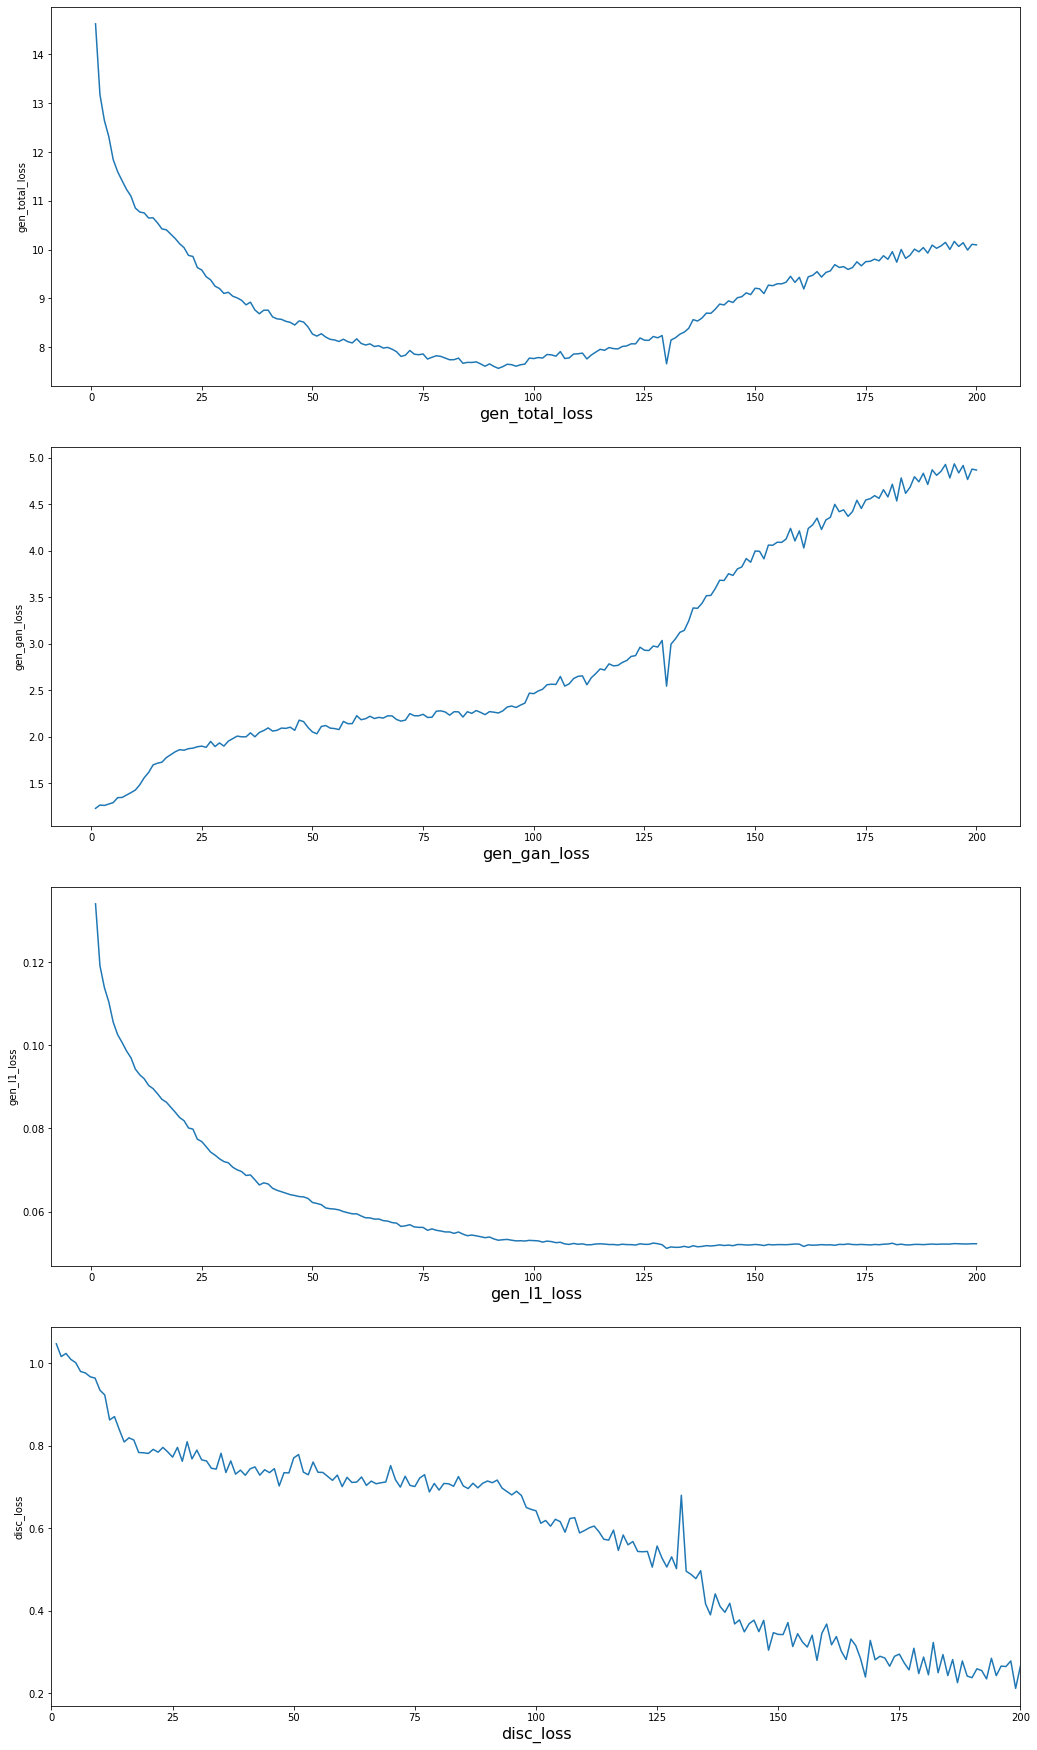

In [4]:
log_file = '../logs/pix2pix/epoch_data.csv'
columns = ['epoch', 'gen_total_loss', 'gen_gan_loss', 'gen_l1_loss', 'disc_loss']
pix2pix_df = logs.parse_logs(log_file, columns, scale = True, plot = True)

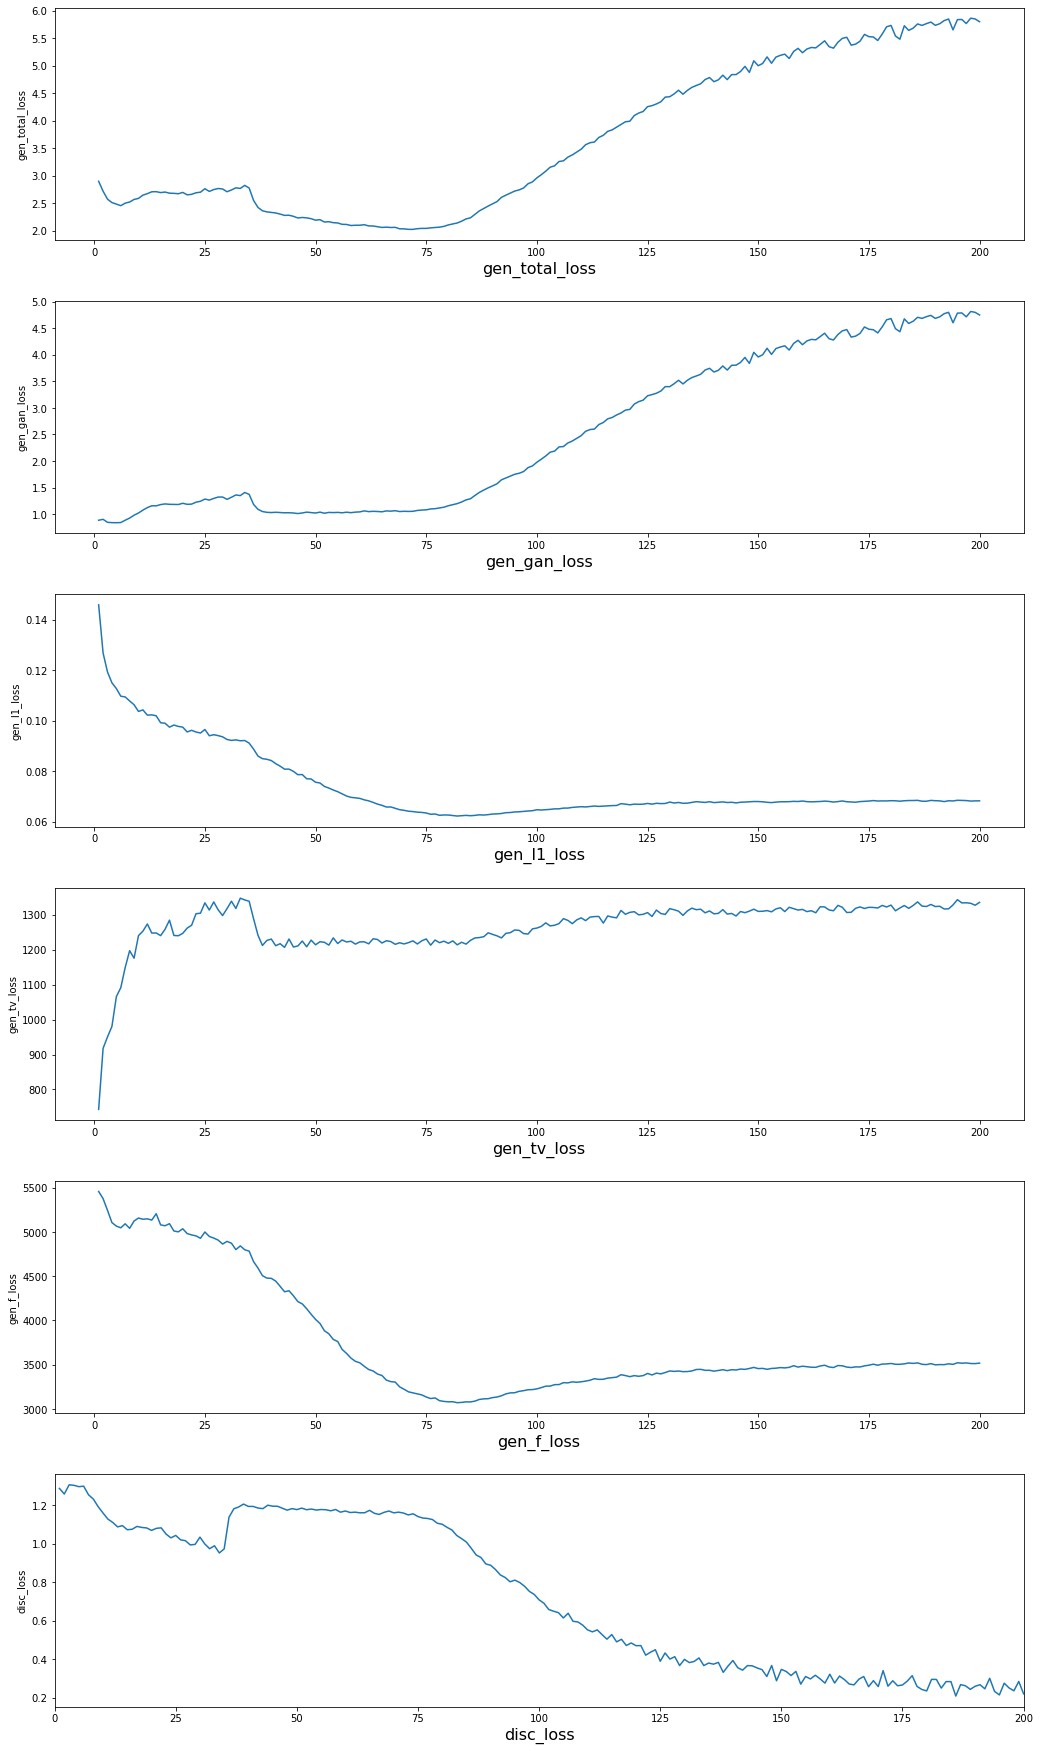

In [5]:
log_file = '../logs/autopainter/epoch_data.csv'
columns = ['epoch', 'gen_total_loss', 'gen_gan_loss', 'gen_l1_loss', 'gen_tv_loss', 'gen_f_loss', 'disc_loss']
autopainter_df = logs.parse_logs(log_file, columns, scale = True, plot = True)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


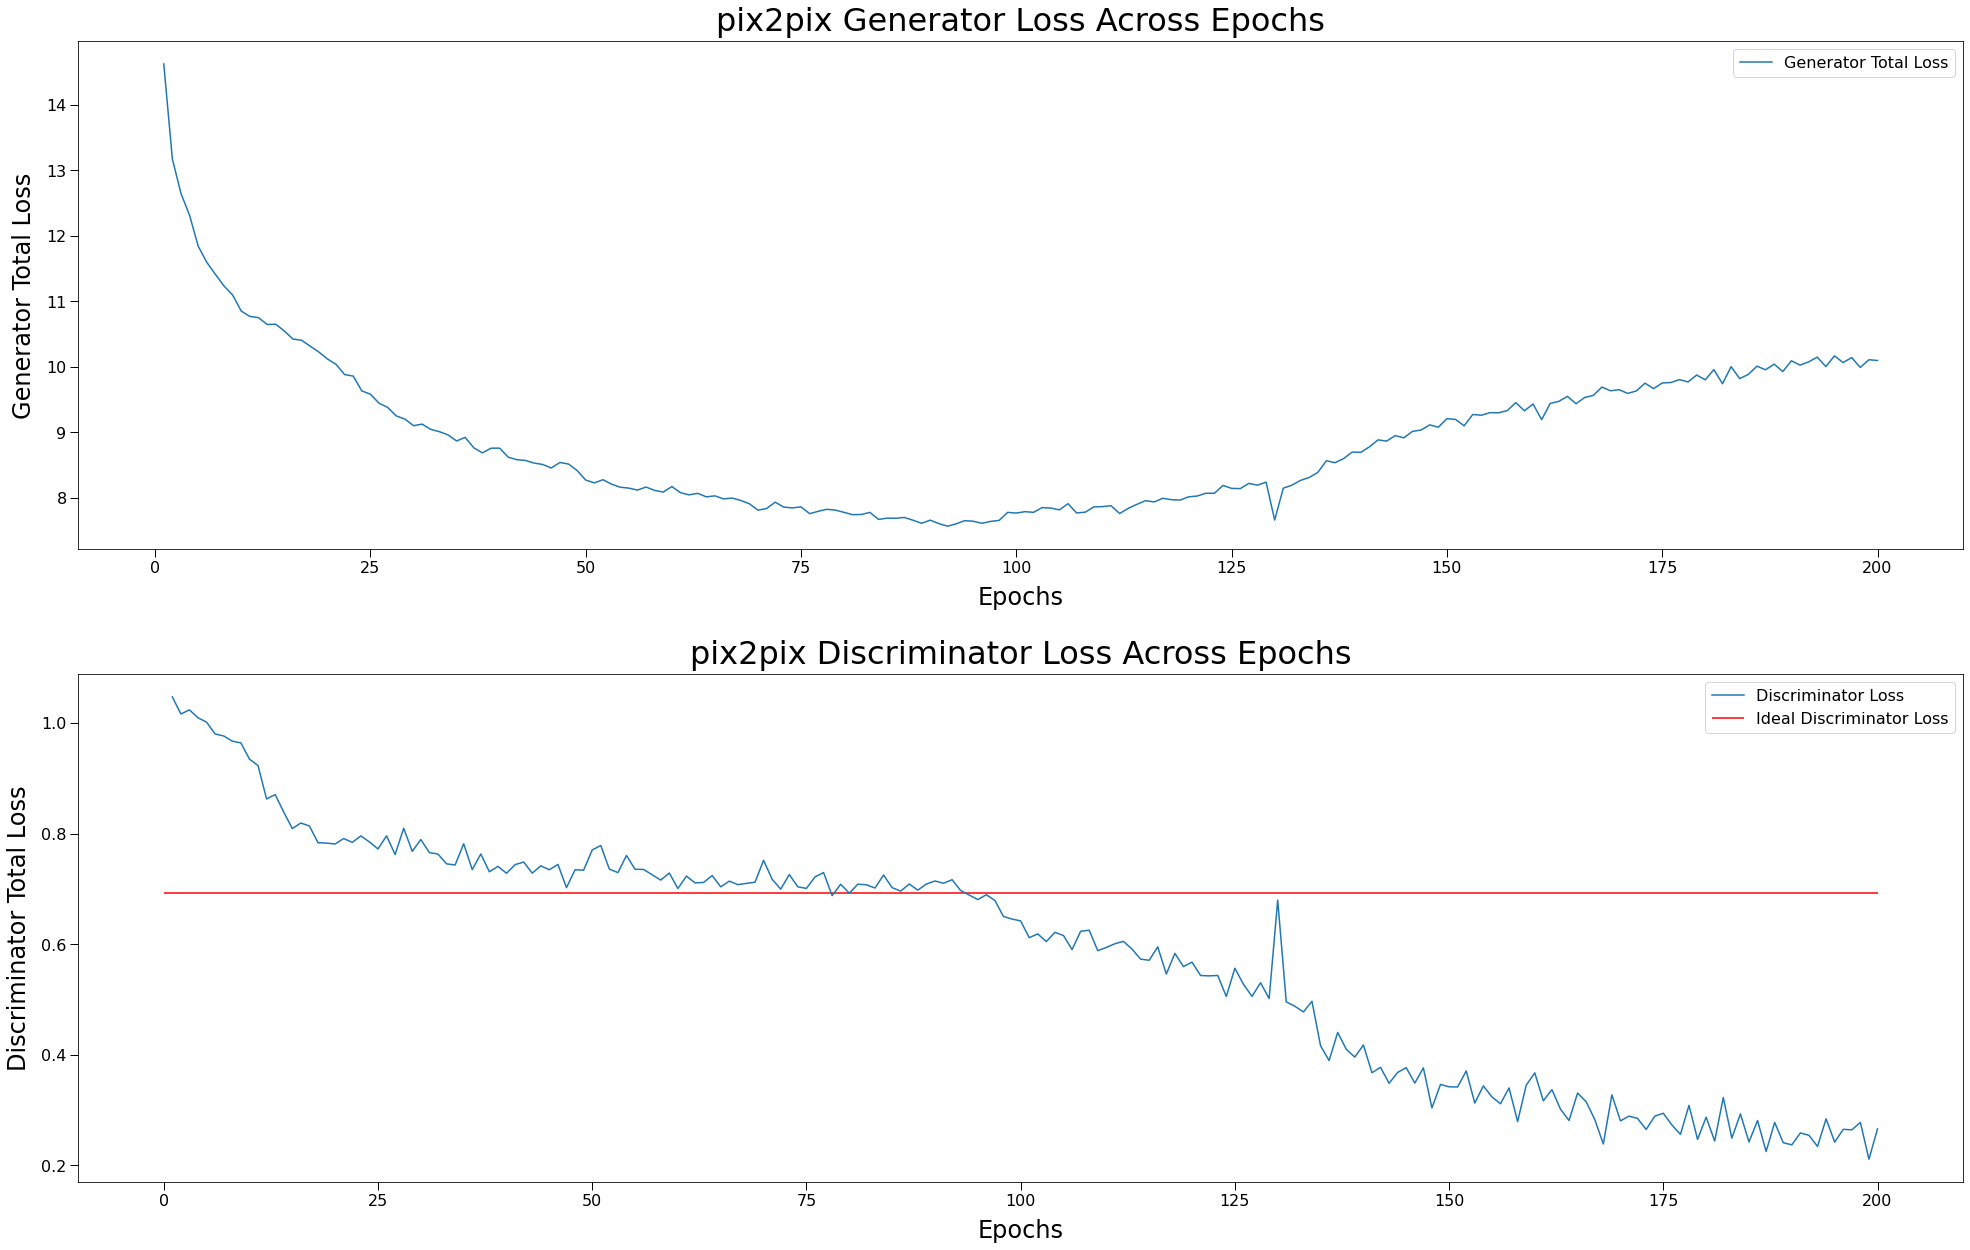

In [6]:
fig = logs.plot_gen_and_disc_losses(pix2pix_df, 'pix2pix')
# plt.savefig('../visualizations/model_health/pix2pix_losses.png', format = 'png', bbox_inches = 'tight')
plt.show()

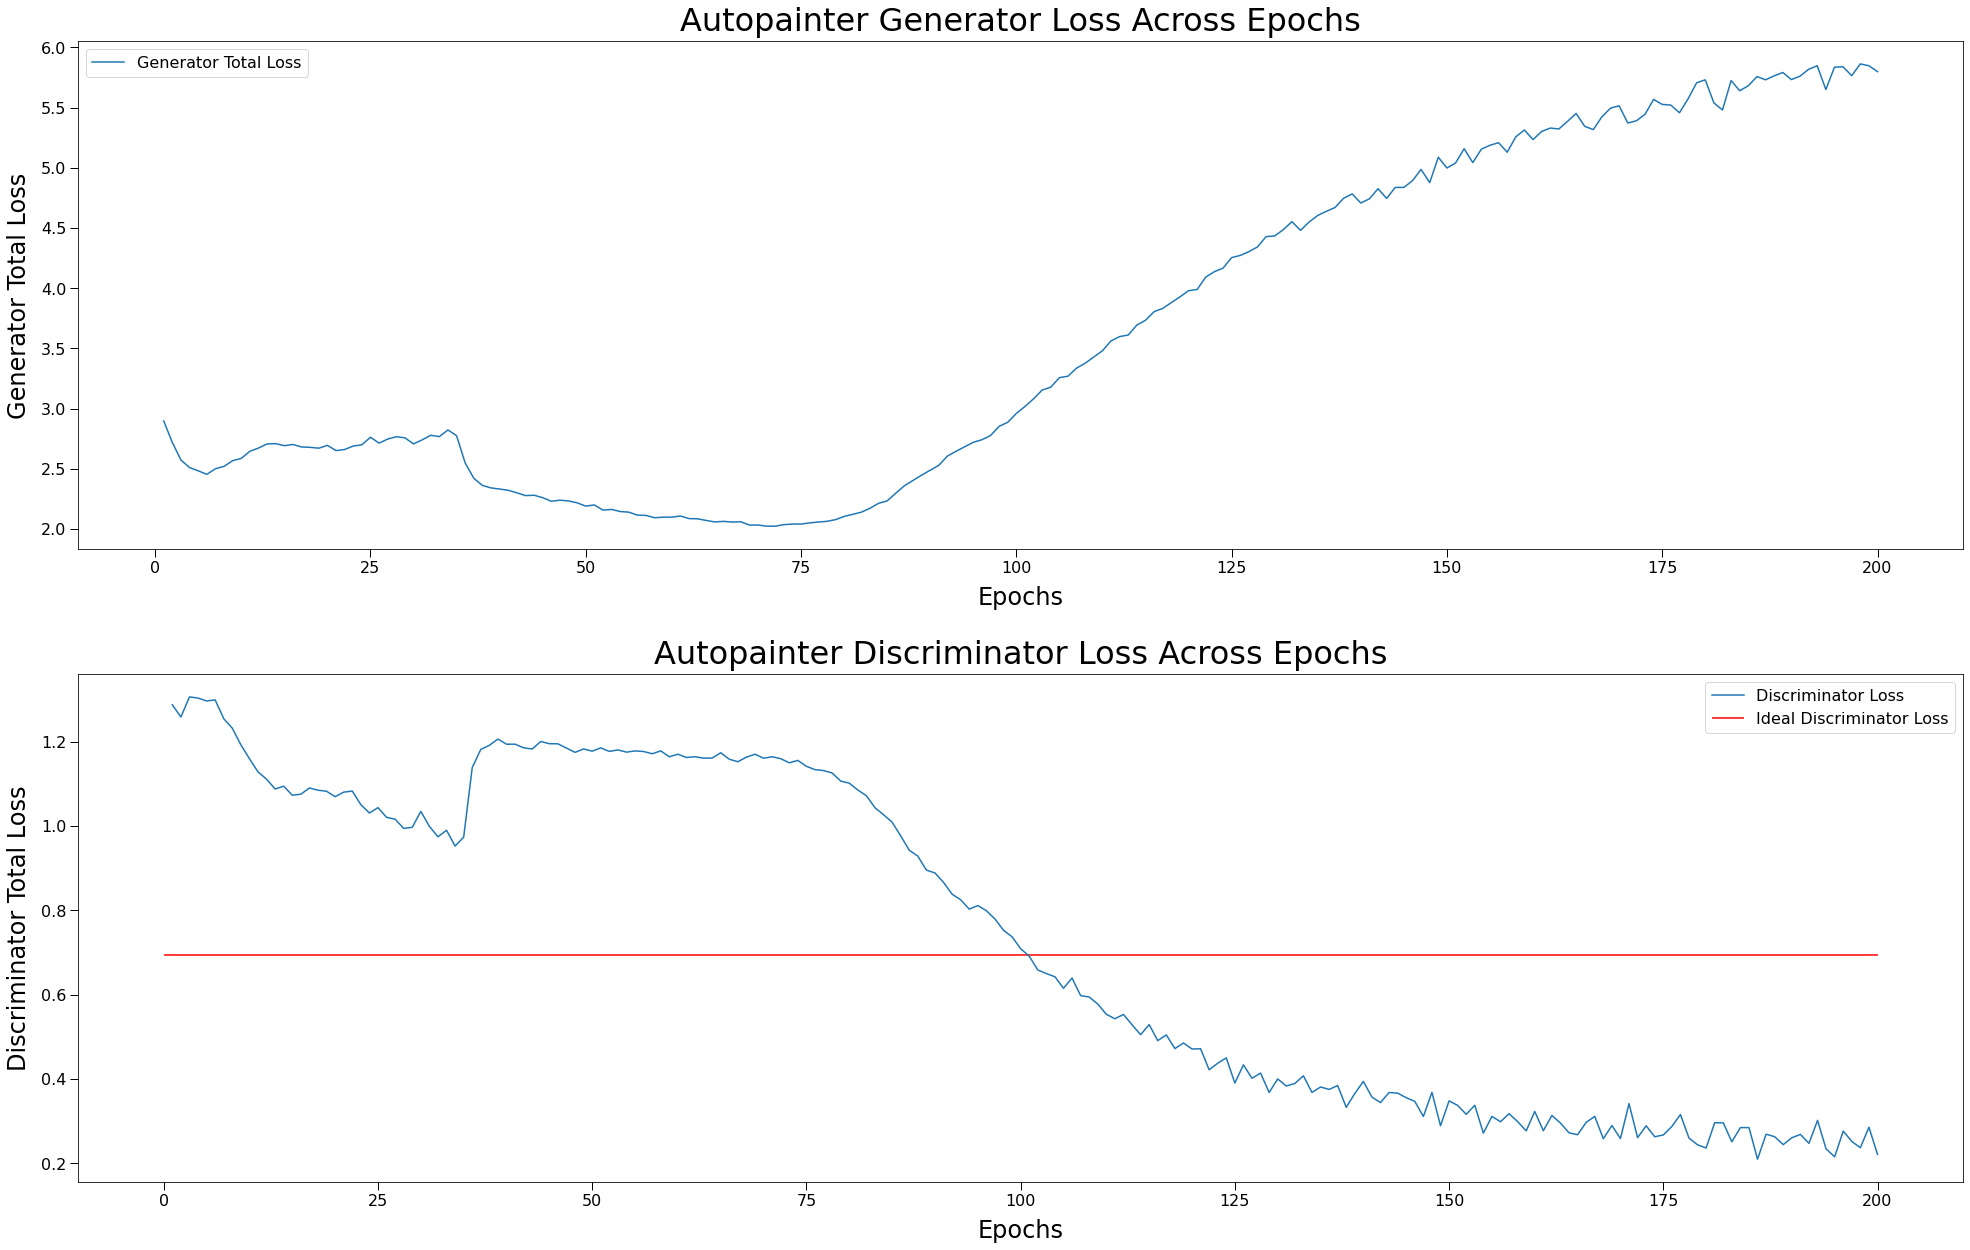

In [7]:
fig = logs.plot_gen_and_disc_losses(autopainter_df, 'Autopainter')
# plt.savefig('../visualizations/model_health/autopainter_losses.png', format = 'png', bbox_inches = 'tight')
plt.show()

## Parse FID Scores

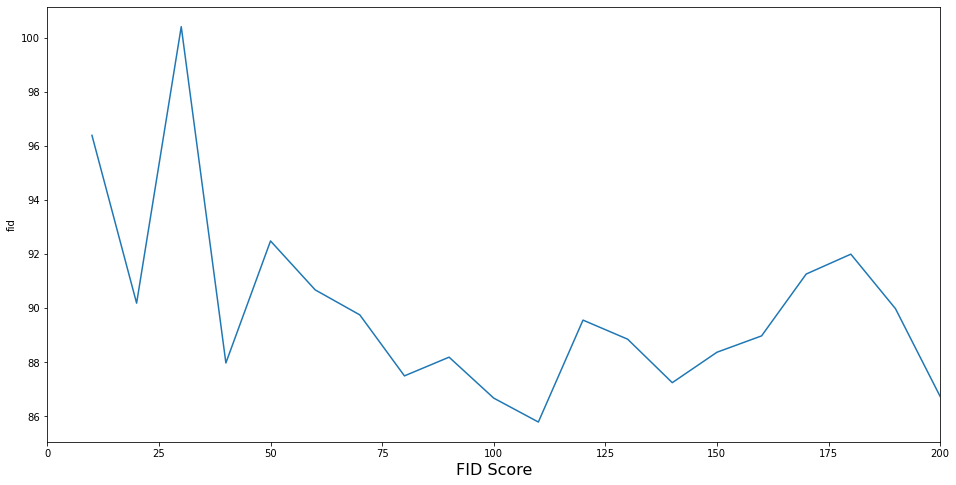

In [8]:
fid_file = '../logs/pix2pix/fid_scores.csv'
pix2pix_fid = fid.parse_fid_logs(fid_file, plot = True)

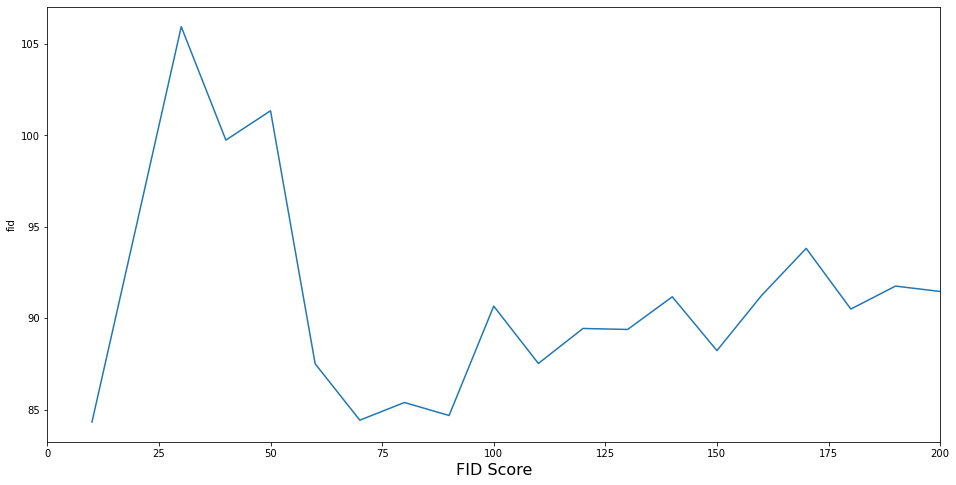

In [9]:
fid_file = '../logs/autopainter/fid_scores.csv'
autopainter_fid = fid.parse_fid_logs(fid_file, plot = True)

In [10]:
merged_fid = autopainter_fid.merge(pix2pix_fid, on = 'epoch', suffixes = ('_autopainter', '_pix2pix'))

In [11]:
autopainter_fid.sort_values('fid')

,epoch,fid
19,10,84.315
13,70,84.417
11,90,84.673
12,80,85.384
14,60,87.503
9,110,87.521
5,150,88.225
7,130,89.382
8,120,89.436
2,180,90.499


In [12]:
merged_fid

,epoch,fid_autopainter,fid_pix2pix
0,200,91.462,86.736
1,190,91.756,89.980
2,180,90.499,91.997
3,170,93.821,91.262
4,160,91.242,88.974
5,150,88.225,88.369
6,140,91.170,87.244
7,130,89.382,88.852
8,120,89.436,89.558
9,110,87.521,85.788


In [13]:
merged_fid.nsmallest(5, 'fid_autopainter')

,epoch,fid_autopainter,fid_pix2pix
19,10,84.315,96.391
13,70,84.417,89.751
11,90,84.673,88.187
12,80,85.384,87.495
14,60,87.503,90.677


In [14]:
merged_fid.nsmallest(5, 'fid_pix2pix')

,epoch,fid_autopainter,fid_pix2pix
9,110,87.521,85.788
10,100,90.659,86.673
0,200,91.462,86.736
6,140,91.170,87.244
12,80,85.384,87.495


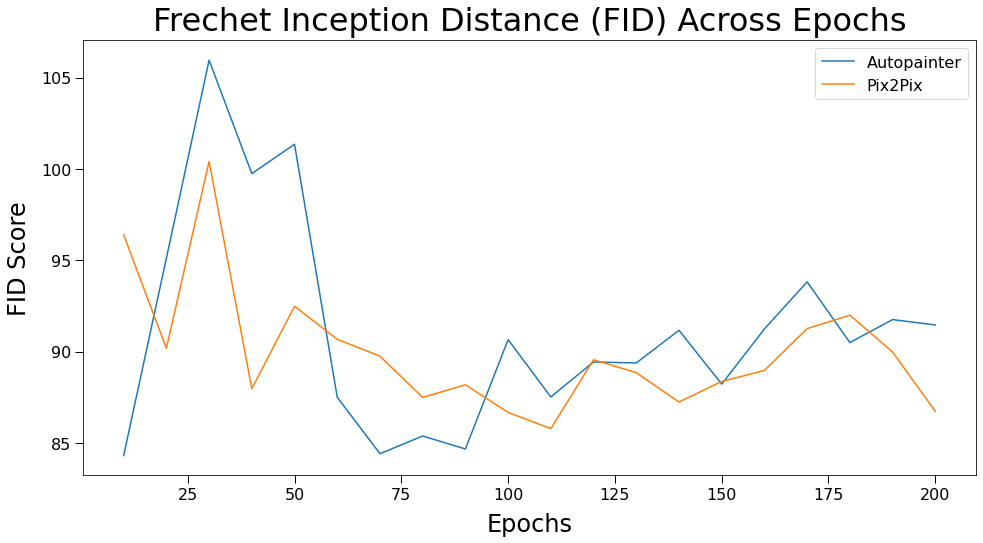

In [15]:
fig = fid.plot_fid_scores(merged_fid)
# plt.savefig('../visualizations/model_health/FID_scores.png', format = 'png', bbox_inches = 'tight')